# Predicting various tickers from yfinance

Author: Scott Sibley

Course Project, UC Irvine, Math 10, Fall 24

I would like to post my notebook on the course's website. Yes

## Introduction
The purpose of this project is to analyze the behavior of some stocks and commodities, and try to find different prediction models to optimise portfolios of multiple different investments.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns

## Importing Data
I will use the yfinance library to pull data directly, as it gives a convinient way to find large quantities of different data.

In [49]:
tickers=['AAPL','SPY','GC=F','SI=F']
n_tickers=len(tickers)
Close=pd.DataFrame()
for ticker in tickers:
    data = yf.Ticker(ticker).history(start='2001-01-01', end='2025-06-01')
    Close[ticker] = data['Close']
FullData=[]

Close.head()
for ticker in tickers:
    FullData.append(yf.Ticker(ticker).history(start='2001-01-01', end='2025-06-01'))

## Clean and Understand our Data

### Check our dataset for missing or NaN values

In [50]:
print(Close.isna().sum())
for i in range(n_tickers):
    print(FullData[i].isna().sum())
Close.dropna(inplace=True)

AAPL     0
SPY      0
GC=F    18
SI=F    17
dtype: int64
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Capital Gains    0
dtype: int64
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


As we can see, there very few NaN values, meaning we are safe to proceed by just dropping them.

### Find log returns
Using the logarithm of the returns lets us add returns, and might be useful later

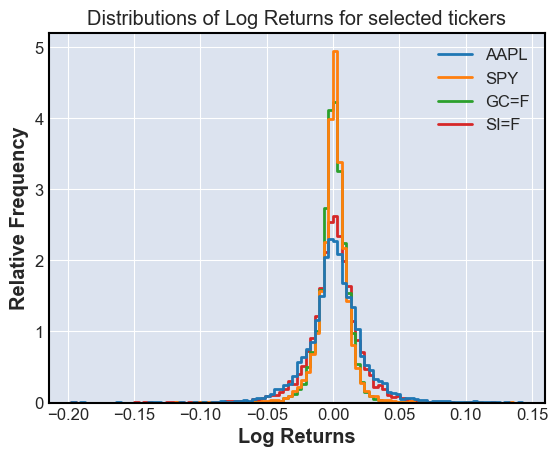

In [51]:
log_returns = np.log(Close/Close.shift(1))
log_returns = log_returns.dropna()
sns.histplot(log_returns,bins=100,element='step',stat='percent',fill=False)
plt.title('Distributions of Log Returns for selected tickers')
plt.xlabel('Log Returns')
plt.ylabel('Relative Frequency')
plt.show()

### Finding Covarience and Correlations
We will use the covarience and correlation of different stocks to hedge our risk

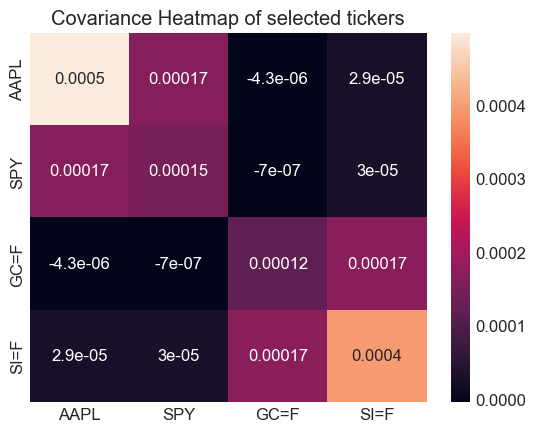

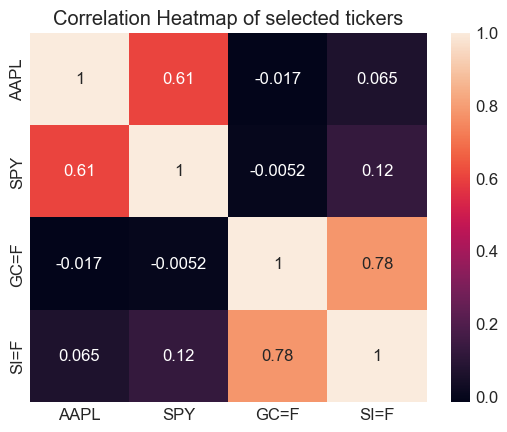

In [52]:
Corr=log_returns.corr()
Cov=log_returns.cov()
sns.heatmap(Cov,annot=True)
plt.title('Covariance Heatmap of selected tickers')
plt.figure()
sns.heatmap(Corr,annot=True)
plt.title('Correlation Heatmap of selected tickers')
plt.show()

## Visualizations
We now want to visualize our data, and see moving averages
I will use mplfinance, a library built on matplotlib, to show these plots.

Stock or commodity prices with 7,30 and 365 day moving averages 



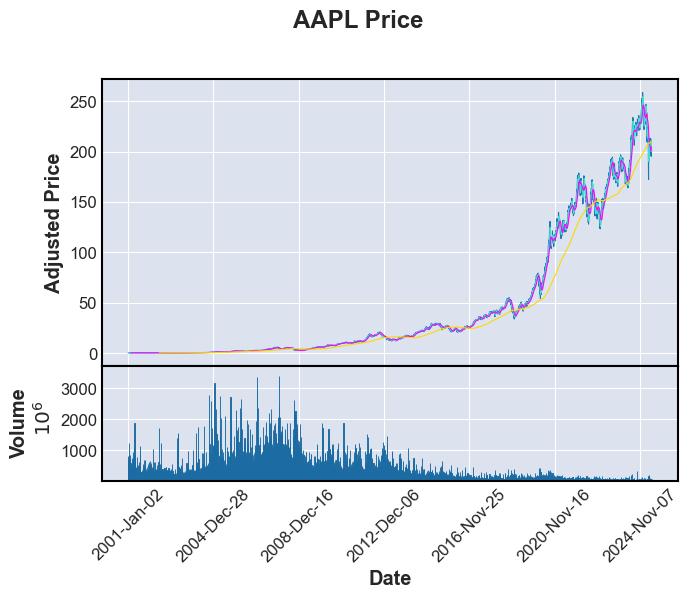

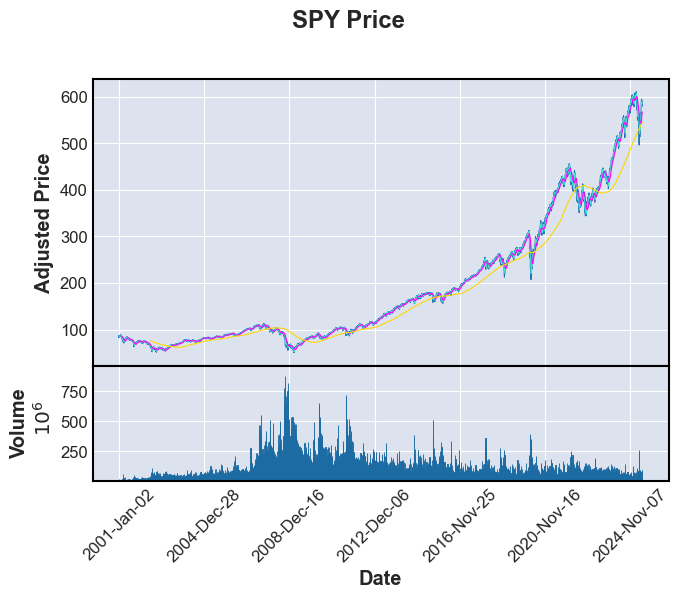

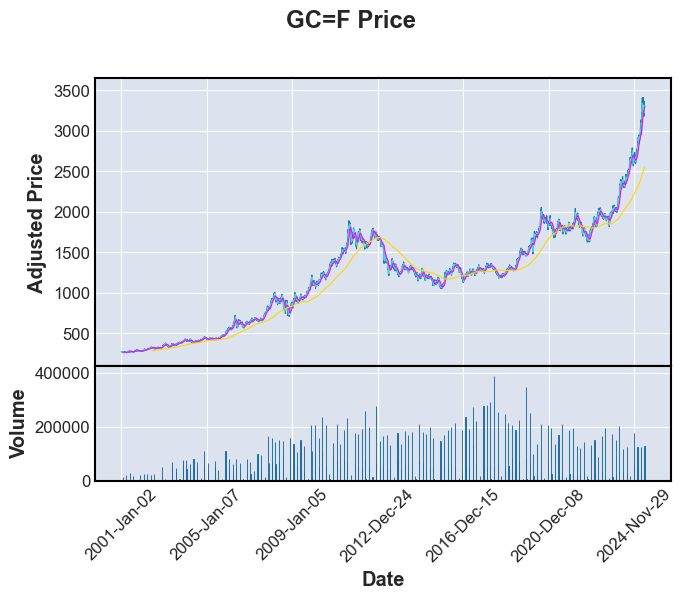

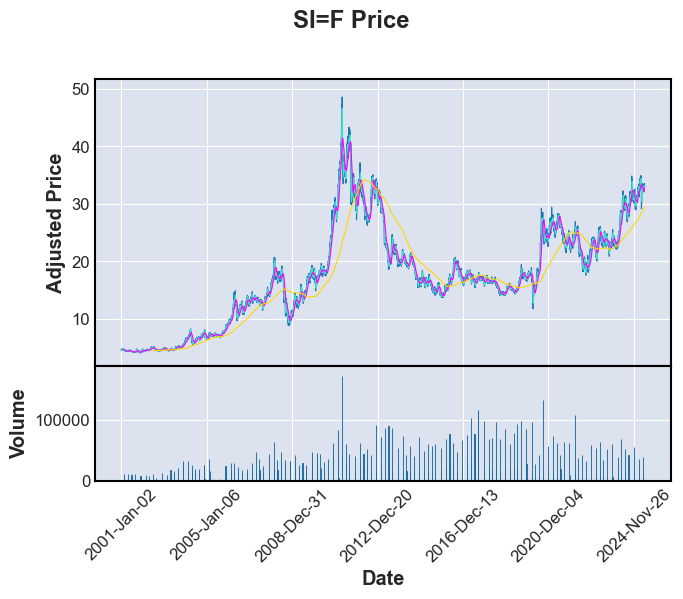

In [53]:
import mplfinance as fplt
print("Stock or commodity prices with 7,30 and 365 day moving averages \n")
for i in range(n_tickers):
    fplt.plot(FullData[i],volume=True,type='line',mav=(7,30,365),title=f'{tickers[i]} Price',xlabel='Date',ylabel='Adjusted Price',ylabel_lower='Volume')

# Linear Regression of a single ticker
**For these, change the ticker list to only 1 or 2 tickers, else many plots and regressions will be run**

In [54]:
#Workaround to prevent too many plots and regressions from happening
#Forces us only to take the first ticker no matter the actual number of tickers selected earlier
n_tickers=2

#### Imports

In [55]:
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

#### Get Features/ Feature Engineering
We can use moving averages and past data to predict the forwards data

In [56]:
Regression_features=[]
for i in range(len(tickers)):
    Lag1=Close[tickers[i]].shift(1).rename('Lag1')
    Lag5=Close[tickers[i]].shift(5).rename('Lag5')
    Lag30=Close[tickers[i]].shift(30).rename('Lag30')
    MA5=Close[tickers[i]].rolling(window=5).mean().rename('MA5')
    MA30=Close[tickers[i]].rolling(window=30).mean().rename('MA30')
    MA90=Close[tickers[i]].rolling(window=90).mean().rename('MA90')
    Target=Close[tickers[i]].rename('Close')
    Vol=FullData[i]['Volume'].rename('Vol')
    Regression_features.append(pd.concat([Lag1,Lag5,Lag30,MA5,MA30,MA90,Vol,Target],axis=1).dropna())

#### Train-test split and k-fold cross validation on Linear Model
We want to use k-fold splits to test many different possible linear models

In [58]:
features=['Lag1','Lag5','Lag30','MA5','MA30','MA90','Vol']
goal='Close'
for i in range(n_tickers):
    X=Regression_features[i][features]
    y=Regression_features[i][goal]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model=LinearRegression()
    linear=LinearRegression()
    linear.fit(X_train,y_train)
    scores=cross_val_score(model,X_train,y_train,cv=kf,scoring='r2')
    mse=mean_squared_error(y_test,linear.predict(X_test))
    r2test=r2_score(y_test,linear.predict(X_test))
    print(f"For Linear Regression {tickers[i]} R^2 scores for each split: {scores} \n mean squared error: {mse} \n r2 score: {r2test}")


For Linear Regression AAPL R^2 scores for each split: [0.99955373 0.99945564 0.99950088 0.99961959 0.99947949] 
 mean squared error: 1.235744198839389 
 r2 score: 0.9997012962273906
For Linear Regression SPY R^2 scores for each split: [0.99971156 0.99967349 0.99968147 0.99973096 0.99961794] 
 mean squared error: 4.735684177047314 
 r2 score: 0.9997645278074918


#### Results
* These are very good results, with very high $R^2$ values and low MSE

#### Ridge Regression and Lasso Regression
* We must scale the features to ensure that the magnitude of the features do not affect the model

In [59]:
for i in range(n_tickers):
    X=Regression_features[i][features]
    y=Regression_features[i][goal]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    model=Ridge()
    model.fit(X_train,y_train)
    mse=mean_squared_error(y_test,model.predict(X_test))
    r2test=r2_score(y_test,model.predict(X_test))
    print(f"For Ridge Regression {tickers[i]} mean squared error: {mse} \n r2 score: {r2test}")
for i in range(n_tickers):
    X=Regression_features[i][features]
    y=Regression_features[i][goal]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    model=Lasso()
    model.fit(X_train,y_train)
    mse=mean_squared_error(y_test,model.predict(X_test))
    r2test=r2_score(y_test,model.predict(X_test))
    print(f"For Ridge Regression {tickers[i]} mean squared error: {mse} \n r2 score: {r2test}")

For Ridge Regression AAPL mean squared error: 1.3631638844383196 
 r2 score: 0.9996704963734816
For Ridge Regression SPY mean squared error: 5.276298278192233 
 r2 score: 0.9997376468790055
For Ridge Regression AAPL mean squared error: 2.1932754848568483 
 r2 score: 0.9994698420091198
For Ridge Regression SPY mean squared error: 6.296458811704498 
 r2 score: 0.9996869214867378


#### Results
* These are slightly worse than the linear model, likely because of the low dimentionality of our data

### Plotting the Linear Model

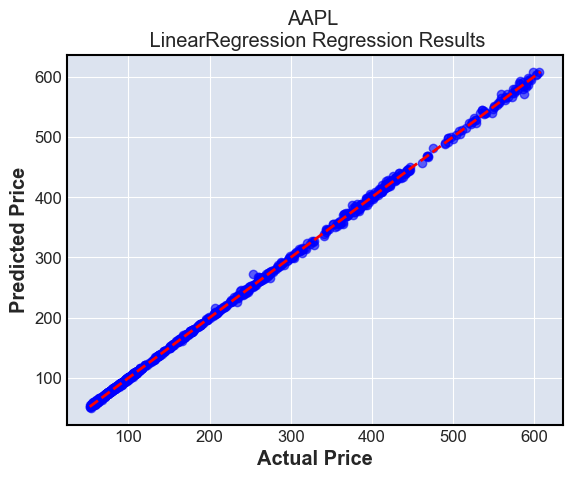

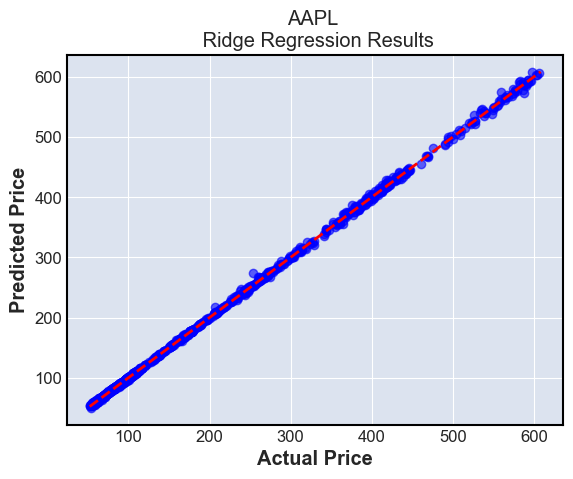

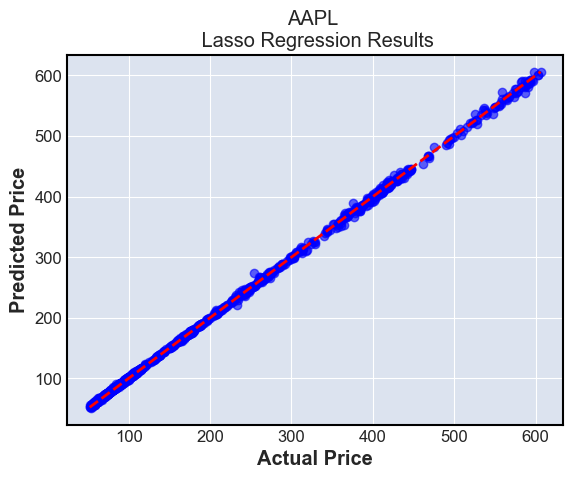

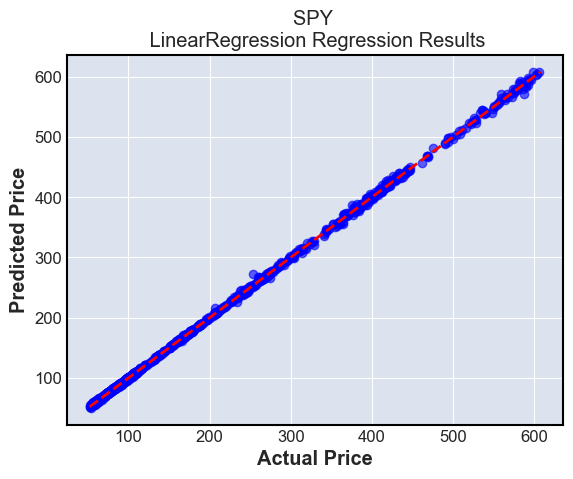

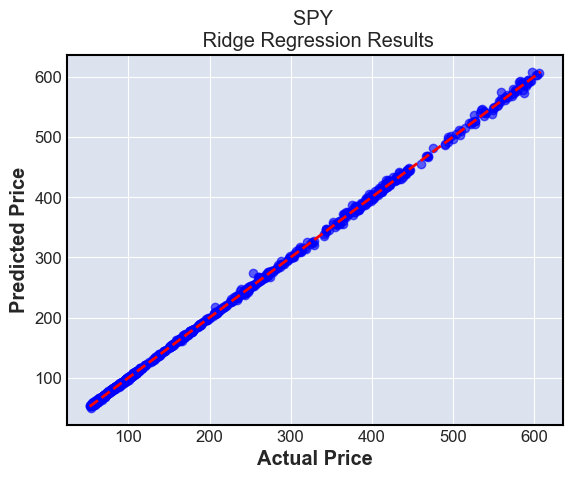

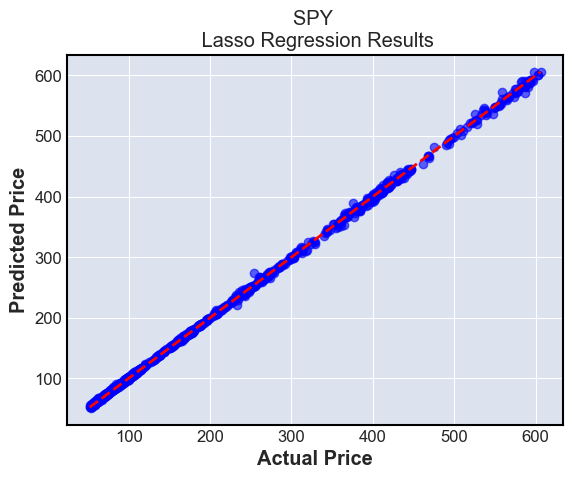

In [60]:
for i in range(n_tickers):
    for modeln in [LinearRegression, Ridge, Lasso]:
        model=modeln()
        model.fit(X_train,y_train)
        plt.scatter(y_test, model.predict(X_test), alpha=0.6, color='blue')
        plt.plot([y_test.min(), model.predict(X_test).max()], [y_test.min(), model.predict(X_test).max()], 'r--', linewidth=2)
        plt.title(f'{tickers[i]} \n {type(modeln()).__name__} Regression Results')
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.grid(True)
        plt.show()

These plots simply show the predictions compared to the ground truth. The ground truth is the diagonal line  $y=x$, and we can see that most predictions are very close to this line

### Summary:
* Linear regression with or without a penalty term perform well in predicting future stock prices, but are limited to making only one days worth of predictions using this method.
* The bias of this model over a longer span is high, because in reality, market data is not driven linearly. The varience is not as high, as we have fit a large amount of data to our models

## k-NN prediction models

#### Imports

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score


Return to using all tickers

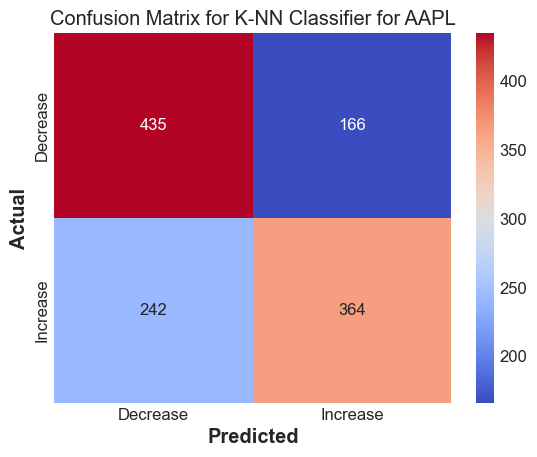

Accuracy score for AAPL : 0.6619718309859155 
 F1 score for AAPL : 0.6408450704225352


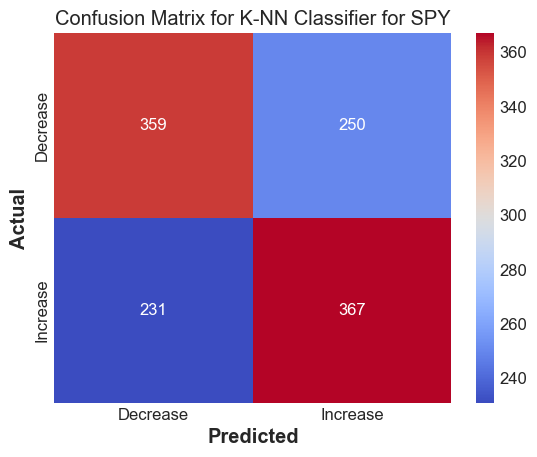

Accuracy score for SPY : 0.6014913007456504 
 F1 score for SPY : 0.6041152263374485


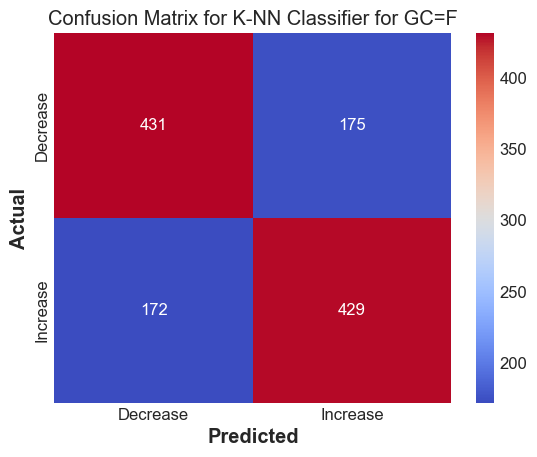

Accuracy score for GC=F : 0.7125103562551781 
 F1 score for GC=F : 0.7120331950207469


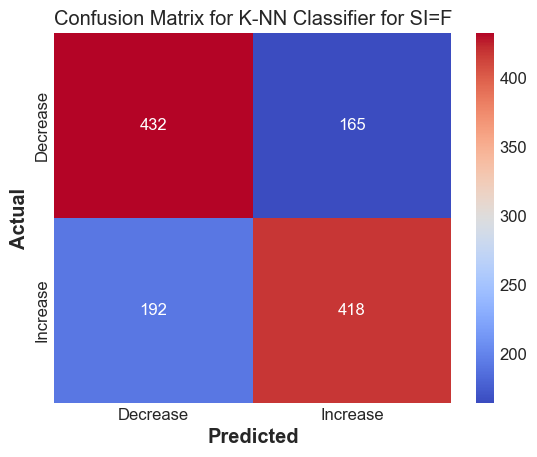

Accuracy score for SI=F : 0.704225352112676 
 F1 score for SI=F : 0.7007544006705784


In [62]:
n_tickers=len(tickers) #If desired
for i in range(n_tickers):
    X=Regression_features[i][features]
    y=Regression_features[i][goal]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    k=7
    knn = KNeighborsClassifier(n_neighbors=k)
    ytr_discrete= y_train > y_train.shift(-1)
    yts_discrete= y_test > y_test.shift(1)
    #We want to see if we go up or down in the next day
    knn.fit(X_train, ytr_discrete)
    # Predict on the test set
    y_pred_knn = knn.predict(X_test)
    conf_matrix = confusion_matrix(yts_discrete, y_pred_knn)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
    plt.title(f'Confusion Matrix for K-NN Classifier for {tickers[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(f'Accuracy score for {tickers[i]} : {accuracy_score(yts_discrete, y_pred_knn)} \n F1 score for {tickers[i]} : {f1_score(yts_discrete, y_pred_knn)}')

### Results
* The k-NN method works decently well to predict whether we expect the stock to go up or down

## Random Forest based model
* These models work by generating many decision trees, and taking the average answer to determine its output

Imports

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Fitting the basic Random Forest
* Generates trees randomly from subsets of the training data

In [ ]:
RF_models=[]
for i in range(n_tickers):
    X=Regression_features[i][features]
    y=Regression_features[i][goal]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    RF_models.append(rf)
    print(f"Random Forest mse for {tickers[i]}:{mean_squared_error(y_test, y_pred_rf)}")
    print(f"Random Forest R2 for {tickers[i]}: {r2_score(y_test, y_pred_rf)}")


Fitting the Gradient Boosting model
* Generates successive trees to try to improve on past trees

In [ ]:
GB_models=[]
for i in range(n_tickers):
    X=Regression_features[i][features]
    y=Regression_features[i][goal]
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_test)
    GB_models.append(gb)
    print(f"Gradient boosting mse for {tickers[i]}:{mean_squared_error(y_test, y_pred_gb)}")
    print(f"Gradient boosting R2 for {tickers[i]}: {r2_score(y_test, y_pred_gb)}")

### Read into the models to see which features are used most
* Find the importances of the features in each model

In [ ]:
for i in range(n_tickers):
    for models in [RF_models, GB_models]:
        importances = models[i].feature_importances_
        importances.sort()
        importances=importances[::-1]
        plt.bar(features, importances)
        plt.title(f'Feature Importances for {tickers[i]} using {type(models[i]).__name__}')
        plt.ylabel('Importance')
        plt.show()

In [ ]:
for i in range(n_tickers):
    for models in [RF_models, GB_models]:
        y_pred=models[i].predict(X_test)
        plt.scatter(y_test, y_pred, alpha=0.6, color='green', label='Predicted vs Actual')
        plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'r--', linewidth=2)
        plt.title(f'{tickers[i]} Predictions vs. Actual using {type(models[i]).__name__}')
        plt.xlabel('Actual Prices')
        plt.ylabel('Predicted Prices')
        plt.legend()
        plt.grid(True)
        plt.show()

## Results using Random Forest and Gradient Boosting
* These have a similar mse and r2 as the linear models, but may be better because they allow for use of nonlinear features
* We can also see that the results from 1 day ago are the best predictor for the results for today, which makes sense
* However, for the AAPL, there is misfitting for higher values, which is a drawback of tree-based designs

## Summary and Conclusion
* Using Linear, k-NN and Random Forest/Gradient Boosting algorithms, we were able to get very accurate predictions for stock prices one day in the future from lagging and moving average data.
* The linear models, though fit well, high bias as stocks cannot be modeled linearly
* The k-NN models are decently accurate at predicting discrete data if the stock will go up or down.
* The tree based models have lower bias, but high variance from possibilities of overfitting or underfitting as they are sensitive to hyperparameters.

### References
* I took inspiration from previous math 10 projects done Hailili Subinuer and James Cho
* I used the documentation for yfinance, matplotlib, mplfinance, seaborn, and sklearn to aid in plotting and doing regression